#Assignment04. Origin-Destination Analysis with NetworkX

##Install and Import Packages

In [1]:
# Install packages

!pip install fiona
!pip install geopandas
!pip install folium
!pip install sodapy -q
!pip install adjustText
!pip install plotly --upgrade
!pip install contextily
!pip install mapclassify
!pip install chart-studio
!sudo apt install libspatialindex-dev
!pip install rtree
!pip install pygeos

     |████████████████████████████████| 15.4 MB 16.1 MB/s 
     |████████████████████████████████| 1.0 MB 13.9 MB/s 
     |████████████████████████████████| 6.3 MB 46.5 MB/s 
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=9bfed89709db89718b6570dcf9cd84ecfc9954e97b8033bdc951d23c981f0d8f
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 64 kB 2.7 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NE

In [2]:
!pip install decorator
!pip install pandapower

     |████████████████████████████████| 5.8 MB 12.3 MB/s 
     |████████████████████████████████| 149 kB 48.1 MB/s 
     |████████████████████████████████| 3.6 MB 57.4 MB/s 
  Created wheel for pandapower: filename=pandapower-2.7.0-py3-none-any.whl size=5777358 sha256=1e2af88aa0f2a9a57e4c356773b9208619bb90ed1e1956ec4e9eb5c78a44a105
  Stored in directory: /root/.cache/pip/wheels/ff/e6/b6/c9218d5a45a02f4bdb220272f2bac4f59c5b73ed08a08125c3
Successfully built pandapower


In [3]:
# Import packages
# To ignore unimporant system warnings
import warnings
warnings.filterwarnings("ignore")

# We will use Pandas, Numpy, and Matplotlib which is a package for visualization with Python
import pandas as pd
import numpy as np

# Load a required package 
# This is a library for accessing and parsing data through URLs
from urllib.parse import urlencode
import urllib.request, json 
from bs4 import BeautifulSoup # for web scraping
import fiona
import plotly.express as px
import geopandas as gpd
import adjustText as aT
import seaborn as sns # visualization styling package
import plotly.graph_objects as go
import urllib, json
import chart_studio.plotly as py
import chart_studio.tools as tls
import os
import plotly
from sodapy import Socrata
from IPython.display import Image, display
from shapely.geometry import shape
from shapely.geometry import Point 
from shapely.geometry import Polygon
import time
from shapely.geometry import shape
import contextily as ctx
from google.colab import files
from sklearn.preprocessing import MinMaxScaler

import networkx as nx #library supporting networks

%matplotlib inline 
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt
import seaborn as sns # visualization styling package
import folium
from folium.plugins import HeatMap

#Chart Studio API
import chart_studio
username='bkirthi'
api_key='PHHYaOZKZDA7BF3nUUtO'
chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

In [4]:
# import more packages
import plotly.io as pio
pio.renderers.default = "colab"
access_token = 'pk.eyJ1IjoiYmtpcnRoaSIsImEiOiJja3VpdzFiMnoycnYyMzBtYXM1aW1uemd0In0.knHw7eYrN8DvrrBHZugW8Q'
px.set_mapbox_access_token(access_token) # for interactive plotly viz

import plotly.graph_objects as go
import chart_studio.plotly as py
import chart_studio.tools as tls

##Import Citibike Rideshare Data
Downloadable from https://www.citibikenyc.com/system-data. Click “Downloadable files of Citi Bike trip data” or “Download Citi Bike trip history data”.

Here, download the data for novust 2021.


In [37]:
# clone github
!git clone https://github.com/kirthi-b/CitiBike-NetworkX

Cloning into 'CitiBike-NetworkX'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 32 (delta 10), reused 24 (delta 5), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [39]:
nov = pd.read_csv("/content/CitiBike-NetworkX/Data/202111.csv")

In [40]:
nov.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,DF35F0CFE02F24FA,classic_bike,2021-11-10 07:59:48,2021-11-10 08:12:54,Bergen Ave & Stegman St,JC108,McGinley Square,JC055,40.706575,-74.086701,40.725340,-74.067622,casual
1,4D166A3D049BA4F7,classic_bike,2021-11-03 09:41:50,2021-11-03 09:58:29,Bergen Ave & Stegman St,JC108,Lafayette Park,JC078,40.706575,-74.086701,40.713464,-74.062859,casual
2,F4BA689777358AD3,classic_bike,2021-11-10 09:03:46,2021-11-10 09:08:36,Washington St,JC098,Columbus Dr at Exchange Pl,JC106,40.724294,-74.035483,40.716870,-74.032810,member
3,9B9A296982C436CC,classic_bike,2021-11-09 17:00:38,2021-11-09 17:44:40,JC Medical Center,JC011,Grove St PATH,JC005,40.716540,-74.049638,40.719586,-74.043117,member
4,EBC2B8A56E6F168F,classic_bike,2021-11-25 07:15:51,2021-11-25 07:22:06,JC Medical Center,JC011,Hamilton Park,JC009,40.716540,-74.049638,40.727596,-74.044247,member


In [41]:
print(nov.shape)

(60061, 13)


In [42]:
nov = nov[['ride_id','started_at','ended_at','start_station_name','end_station_name','start_lat','start_lng','end_lat','end_lng']]

In [43]:
nov_sub = nov_rev = nov[['start_station_name','start_lat','start_lng']]
nov_sub.shape[0]

60061

In [44]:
nov_rev = nov[['end_station_name','end_lat','end_lng']]
nov_rev = nov_rev.rename(columns={"end_station_name":"start_station_name","end_lat":"start_lat","end_lng":"start_lng"})
nov_rev.shape[0]

60061

In [45]:
#get count of rides per route
nov_count = nov.groupby(['start_station_name','end_station_name']).size().to_frame('count').reset_index()
nov_df = pd.DataFrame(nov_count)
nov_count.head()

,start_station_name,end_station_name,count
0,11 St & Washington St,11 St & Washington St,79
1,11 St & Washington St,12 Ave & W 40 St,1
2,11 St & Washington St,12 St & Sinatra Dr N,12
3,11 St & Washington St,14 St Ferry - 14 St & Shipyard Ln,27
4,11 St & Washington St,4 St & Grand St,32


In [46]:
#get list of all routes
tot = pd.concat([nov_sub,nov_rev])
tot_count = tot.groupby(['start_station_name']).size().to_frame('count').reset_index()
tot_df = pd.DataFrame(tot_count)
tot_df.head()

,start_station_name,count
0,11 Ave & W 59 St,4
1,11 St & Washington St,2624
2,12 Ave & W 40 St,4
3,12 St & Sinatra Dr N,1438
4,14 St Ferry - 14 St & Shipyard Ln,2087


In [47]:
tot.shape[0]

120122

In [48]:
tot = tot.drop_duplicates()
tot.shape[0]

185

In [49]:
tot = pd.merge(tot, tot_df, on="start_station_name")

In [50]:
tot.head()

,start_station_name,start_lat,start_lng,count
0,Bergen Ave & Stegman St,40.706575,-74.086701,121
1,Washington St,40.724294,-74.035483,2134
2,Washington St,40.724294,-74.035483,2134
3,JC Medical Center,40.716540,-74.049638,1234
4,JC Medical Center,40.716540,-74.049638,1234


##Create a Network with CitiBike Station Names as Nodes

In [51]:
#create a dictionary of station locations
stations={}
for c in range(len(tot)):
    stations[tot['start_station_name'][c]]=(tot['start_lng'][c],tot['start_lat'][c])

In [52]:
stations

{'11 Ave & W 59 St': (-73.99046033620834, 40.771496710544405),
 '11 St & Washington St': (-74.02715, 40.749984999999995),
 '12 Ave & W 40 St': (-74.00277668, 40.76087502),
 '12 St & Sinatra Dr N': (-74.02402, 40.750603999999996),
 '14 St Ferry - 14 St & Shipyard Ln': (-74.024353, 40.752961),
 '2 St HBLR - 2 St & Marshall St': (-74.04243484139442, 40.740801901653576),
 '4 St & Grand St': (-74.035111, 40.742258),
 '5 Ave & E 72 St': (-73.96685276, 40.77282817),
 '5 Corners Library': (-74.059503, 40.734961),
 '6 St & Grand St': (-74.03450086712837, 40.744397833095604),
 '7 St & Monroe St': (-74.037977, 40.746413000000004),
 '8 St & Washington St': (-74.028199, 40.745984),
 '9 St HBLR - Jackson St & 8 St': (-74.038412, 40.747907),
 'Adams St & 11 St': (-74.033541, 40.750916),
 'Adams St & 2 St': (-74.036904, 40.739814),
 'Astor Place': (-74.07126188278198, 40.71928220070703),
 'Baldwin at Montgomery': (-74.064194, 40.723659000000005),
 'Bank St & Hudson St': (-74.00618026, 40.73652889),
 '

In [53]:
#create a network with station names as nodes for novust
nov_rides=nx.DiGraph()
nov_rides.add_nodes_from(nov['start_station_name'])

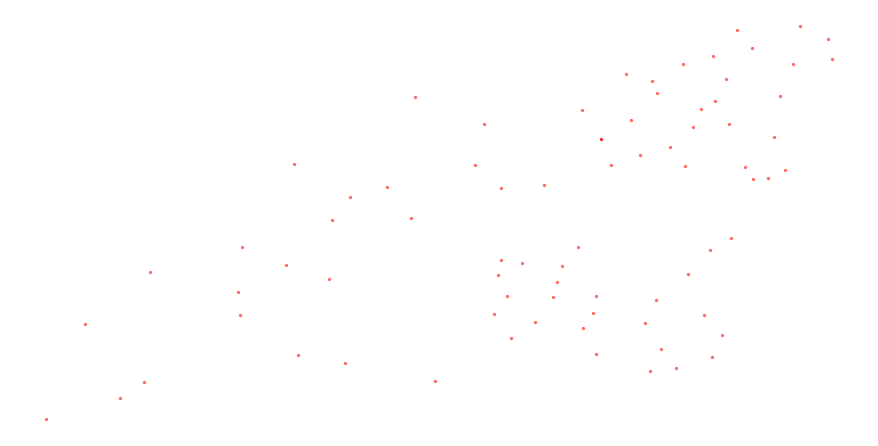

In [54]:
#visualize all the world airport cities
plt.figure(figsize = (12,6))
nx.draw(nov_rides, pos=stations, with_labels=False, arrows=False, node_size=5,
       node_color='red', alpha=0.5)

##Add Edges

In [55]:
# create list of edges as tuples
# create list of 0 first

#for novust
nov_EN=len(nov_df.index)
edgelist=[0]*nov_EN
print (edgelist[:5])

[0, 0, 0, 0, 0]


In [56]:
# create list of edges as tuples for novust
for j in range(0,nov_EN):
    edgelist[j]=(nov_df['start_station_name'][j],nov_df['end_station_name'][j], nov_df['count'][j])
edgelist

[('11 St & Washington St', '11 St & Washington St', 79),
 ('11 St & Washington St', '12 Ave & W 40 St', 1),
 ('11 St & Washington St', '12 St & Sinatra Dr N', 12),
 ('11 St & Washington St', '14 St Ferry - 14 St & Shipyard Ln', 27),
 ('11 St & Washington St', '4 St & Grand St', 32),
 ('11 St & Washington St', '6 St & Grand St', 35),
 ('11 St & Washington St', '7 St & Monroe St', 30),
 ('11 St & Washington St', '8 St & Washington St', 44),
 ('11 St & Washington St', '9 St HBLR - Jackson St & 8 St', 40),
 ('11 St & Washington St', 'Adams St & 11 St', 17),
 ('11 St & Washington St', 'Adams St & 2 St', 18),
 ('11 St & Washington St', 'Astor Place', 1),
 ('11 St & Washington St', 'Bloomfield St & 15 St', 21),
 ('11 St & Washington St', 'Broadway & W 51 St', 1),
 ('11 St & Washington St', 'Brunswick St', 1),
 ('11 St & Washington St', 'Church Sq Park - 5 St & Park Ave', 45),
 ('11 St & Washington St', 'City Hall - Washington St & 1 St', 125),
 ('11 St & Washington St', 'Clinton St & 7 St', 2

In [57]:
# add edges to the network
nov_rides.add_weighted_edges_from(edgelist)

In [58]:
print (nov_rides.in_degree(weight='weight')['Newport PATH'])
print (nov_rides.out_degree(weight='weight')['Newport PATH'])

1550
1543


###Incoming and outgoing degree

In [59]:
# Convert pandas dataframe and join two information - novust
in_degree = pd.DataFrame.from_dict(dict(nov_rides.in_degree()), orient='index').reset_index()
in_degree.columns = ['start_station_name', 'in_degree']
out_degree = pd.DataFrame.from_dict(dict(nov_rides.out_degree()), orient='index').reset_index()
out_degree.columns = ['start_station_name', 'out_degree']

in_degree.head()

,start_station_name,in_degree
0,Bergen Ave & Stegman St,21
1,Washington St,68
2,JC Medical Center,52
3,Pershing Field,58
4,11 St & Washington St,48


In [60]:
in_out_degree = pd.merge(in_degree, out_degree, how='outer', on='start_station_name')
in_out_degree.sort_values(by='in_degree', ascending=False).head(10)

,start_station_name,in_degree,out_degree
15,Newport PATH,74,71
14,Newport Pkwy,74,70
11,Hamilton Park,72,75
30,Grove St PATH,69,69
43,Newark Ave,69,63
17,Harborside,68,62
1,Washington St,68,66
56,Hoboken Terminal - River St & Hudson Pl,68,62
63,Hoboken Ave at Monmouth St,66,67
27,City Hall - Washington St & 1 St,66,66


In [61]:
print(nov_rides.in_degree())
print(nov_rides.out_degree())

[('Bergen Ave & Stegman St', 21), ('Washington St', 68), ('JC Medical Center', 52), ('Pershing Field', 58), ('11 St & Washington St', 48), ('Manila & 1st', 64), ('Jersey & 3rd', 62), ('Sip Ave', 57), ('12 St & Sinatra Dr N', 43), ('Columbus Park - Clinton St & 9 St', 47), ('Mama Johnson Field - 4 St & Jackson St', 50), ('Hamilton Park', 72), ('Jersey & 6th St', 60), ('Adams St & 2 St', 53), ('Newport Pkwy', 74), ('Newport PATH', 74), ('Paulus Hook', 51), ('Harborside', 68), ('Marin Light Rail', 61), ('8 St & Washington St', 58), ('South Waterfront Walkway - Sinatra Dr & 1 St', 64), ('Hilltop', 56), ('Hudson St & 4 St', 61), ('McGinley Square', 52), ('2 St HBLR - 2 St & Marshall St', 22), ('Jackson Square', 26), ('Monmouth and 6th', 49), ('City Hall - Washington St & 1 St', 66), ('4 St & Grand St', 49), ('Church Sq Park - 5 St & Park Ave', 54), ('Grove St PATH', 69), ('Essex Light Rail', 39), ('7 St & Monroe St', 55), ('Adams St & 11 St', 44), ('9 St HBLR - Jackson St & 8 St', 42), ('6 

###Visualize the Citibike Routes Network

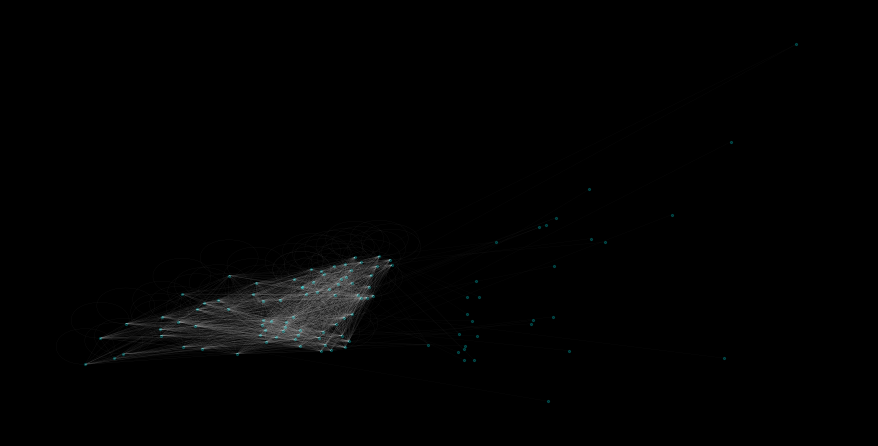

In [72]:
#visualize the network
fig = plt.figure(figsize = (12,6))
nx.draw(nov_rides, pos=stations, with_labels=False, arrows=False, node_size=5,
       node_color='cyan', alpha=0.2, style='dotted', edge_color='white', width=0.2)
fig.set_facecolor("#000")

In [74]:
fig = px.scatter_mapbox(tot,
                    lat='start_lat',
                    lon='start_lng',
                    color_discrete_sequence=px.colors.qualitative.Plotly,
                    mapbox_style='dark',
                    size = 'count',
                    hover_data = {'start_station_name': True})

fig.update_layout(autosize=False,
                 width=1000,
                 height=800)

fig.update_layout(mapbox_zoom=10, 
                  mapbox_center = {"lat": 40.776789, "lon": -73.970212})
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

##Check other centrality scores of stations
* Degree centrality
* Eigenvector centrality

In [64]:
#output top ten centrality scores, given the dictionary d
def topdict(d,tn):
#     ind=sorted(d, key=dict(d).get, reverse=True)
    ind = sorted(dict(c1), key=dict(c1).__getitem__, reverse=True)
    for i in range(0,tn):
        print('{0}|{1}:{2}'.format(i+1,ind[i],d[ind[i]]))

Now compute five centrality metrics - degree, eigenvector, betweenness, closeness and pagerank - and output top 10 stations in terms according to those metrics

In [65]:
# Degree centrality
c1= nx.degree(nov_rides)
topdict(c1,10)

1|Hamilton Park:147
2|Newport PATH:145
3|Newport Pkwy:144
4|Grove St PATH:138
5|Washington St:134
6|Hoboken Ave at Monmouth St:133
7|City Hall - Washington St & 1 St:132
8|Newark Ave:132
9|Harborside:130
10|Columbus Dr at Exchange Pl:130


In [66]:
# Eigenvector centrality
c2= nx.eigenvector_centrality(nov_rides)
topdict(c2,10)

1|Hamilton Park:0.1478389397425787
2|Newport PATH:0.15199105777302752
3|Newport Pkwy:0.15339791576380607
4|Grove St PATH:0.14297406718290512
5|Washington St:0.14454562768161927
6|Hoboken Ave at Monmouth St:0.1400752518882686
7|City Hall - Washington St & 1 St:0.13793660878021205
8|Newark Ave:0.14250815595074934
9|Harborside:0.14218121871982242
10|Columbus Dr at Exchange Pl:0.13302176739850535


In [67]:
#Betweenness centrality
c3 = nx.betweenness_centrality(nov_rides)
topdict(c3,10)

1|Hamilton Park:0.02248959149399908
2|Newport PATH:0.007742490646138058
3|Newport Pkwy:0.006442256466882721
4|Grove St PATH:0.0068770353945249735
5|Washington St:0.004850374438370082
6|Hoboken Ave at Monmouth St:0.005023191385254143
7|City Hall - Washington St & 1 St:0.0054337890397361905
8|Newark Ave:0.005901272355731661
9|Harborside:0.018416901369773503
10|Columbus Dr at Exchange Pl:0.007856644183209447


In [68]:
#Closeness centrality
c4 = nx.closeness_centrality(nov_rides)
topdict(c4,10)

1|Hamilton Park:0.6627450980392157
2|Newport PATH:0.678714859437751
3|Newport Pkwy:0.678714859437751
4|Grove St PATH:0.6401515151515151
5|Washington St:0.6329588014981273
6|Hoboken Ave at Monmouth St:0.619047619047619
7|City Hall - Washington St & 1 St:0.619047619047619
8|Newark Ave:0.6401515151515151
9|Harborside:0.6329588014981273
10|Columbus Dr at Exchange Pl:0.6123188405797101


##Visualize the network with the node size proportional to the degree centrality (or any other centrality)

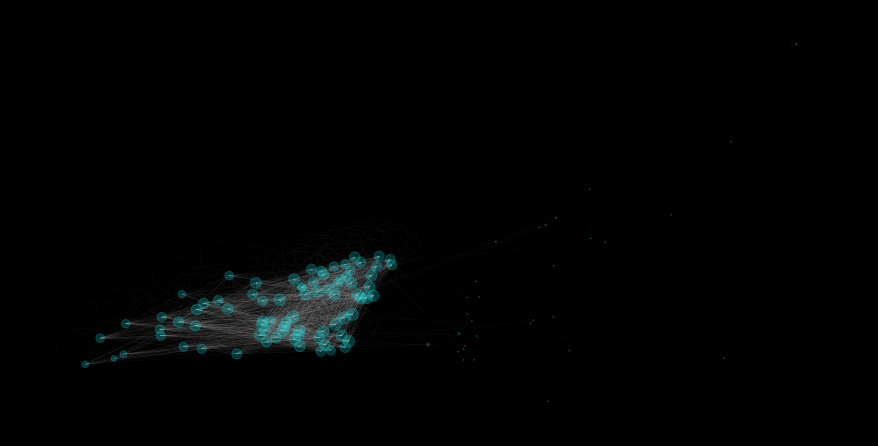

In [73]:
node_size_original = list(dict(c1).values()) # based on degree centrality

#visualize the network
fig = plt.figure(figsize = (12,6))
nx.draw(nov_rides, pos=stations, with_labels=False,arrows=False, 
        node_size=node_size_original, 
       node_color='cyan', alpha=0.2, style='dotted', edge_color='white', width=0.2)
fig.set_facecolor("#000")